In [1]:
import sys
sys.path.append('..')

In [2]:
from utils.LidarCalibration import *
from utils.comp_tools import *


In [3]:
data = read_hdf5_file("../data/calibrated_data_2025_07_04_V2.h5")
print(data.keys())
print(data['atlid_comparison'].keys())
print(data['atlid_comparison']['time_range']['start_time'][()], data['atlid_comparison']['time_range']['end_time'][()])

<KeysViewHDF5 ['atlid_comparison', 'atlid_l2', 'clear_sky', 'cloudy_sky']>
<KeysViewHDF5 ['ATB', 'altitude', 'beta_aerosol_total', 'klett_params', 'time_range']>
b'2025-07-04T01:30:00' b'2025-07-04T03:40:00'


<KeysViewHDF5 ['AMB_355', 'AMB_355_avg', 'APB_355', 'APB_355_avg', 'altitude', 'backscatter_355', 'backscatter_355_avg', 'end_idx', 'interval', 'min_index', 'start_idx']>


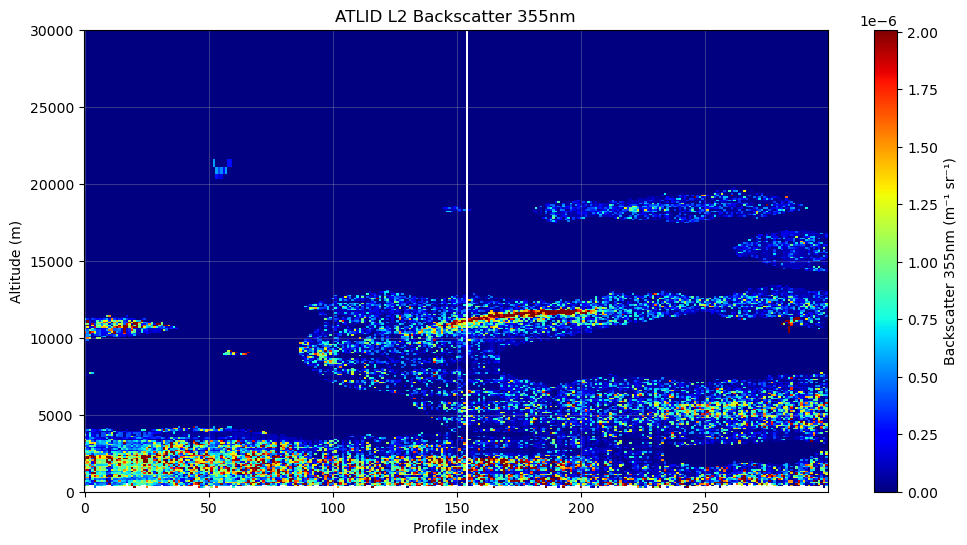

In [4]:
# plot atlid Backscatter 355nm

atlid_data = data['atlid_l2']
print(atlid_data.keys())


alt_atlid = np.array(atlid_data['altitude'])
backscatter_atlid = np.array(atlid_data['backscatter_355'])

plt.figure(figsize=(12, 6))

alt_atlid_avrg = np.nanmean(alt_atlid, axis=0)
profile_indices = np.arange(backscatter_atlid.shape[0])


vmax = np.nanpercentile(backscatter_atlid, 99)
vmin = np.nanpercentile(backscatter_atlid, 10)

plt.pcolormesh(profile_indices, alt_atlid_avrg, backscatter_atlid.T, 
               cmap='jet', vmin=vmin, vmax=vmax, shading='auto')
plt.colorbar(label='Backscatter 355nm (m⁻¹ sr⁻¹)')
plt.xlabel('Profile index')
plt.ylabel('Altitude (m)')
plt.title('ATLID L2 Backscatter 355nm')
plt.ylim(0, 30000)
plt.grid(True, alpha=0.3)
plt.show()


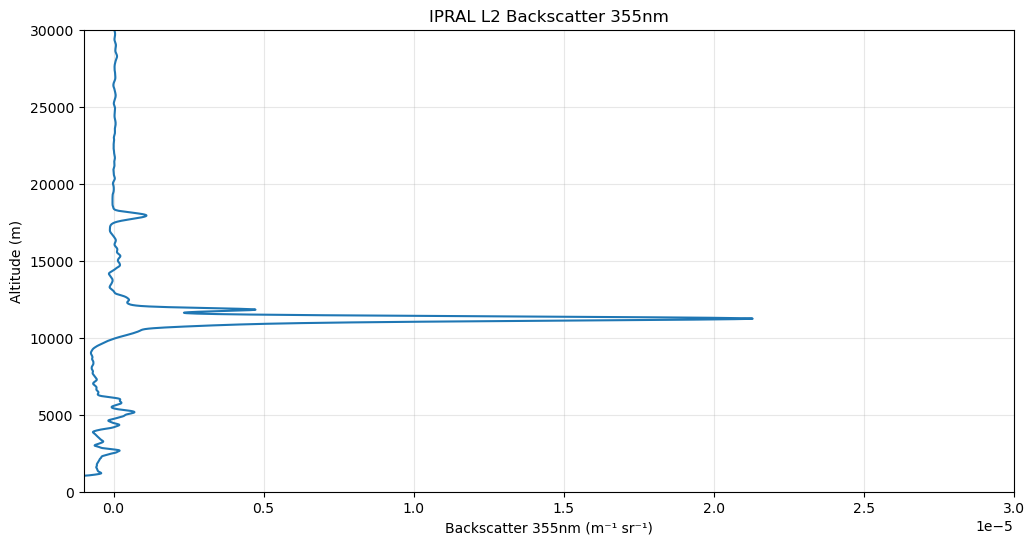

In [5]:
# plot ipral Backscatter 355nm

ipral_data = data['atlid_comparison']
alt_ipral = np.array(ipral_data['altitude'])
backscatter_ipral = np.array(ipral_data['beta_aerosol_total'])
start_time = ipral_data['time_range']['start_time'][()]
end_time = ipral_data['time_range']['end_time'][()] 


plt.figure(figsize=(12, 6))
plt.plot( backscatter_ipral , alt_ipral)
plt.xlabel('Backscatter 355nm (m⁻¹ sr⁻¹)')
plt.ylabel('Altitude (m)')
plt.title('IPRAL L2 Backscatter 355nm')
plt.ylim(0, 30000)
plt.xlim(-1e-6, 3e-5)
plt.grid(True, alpha=0.3)
plt.show()


# compare beta part atlid vs beta part ipral

(60, 242) (60, 242)


/home/aaddouche/Documents/work/taches/tache2/ATLID_ground_observation/ATLID_SIRTA/Klett/Calibration_pipeline/2025_07_04/notebooks/../utils/comp_tools.py:20: RuntimeWarning: Mean of empty slice
  mean_backscatter = np.nanmean(backscatter_atlid[start_idx:end_idx, :], axis=0)


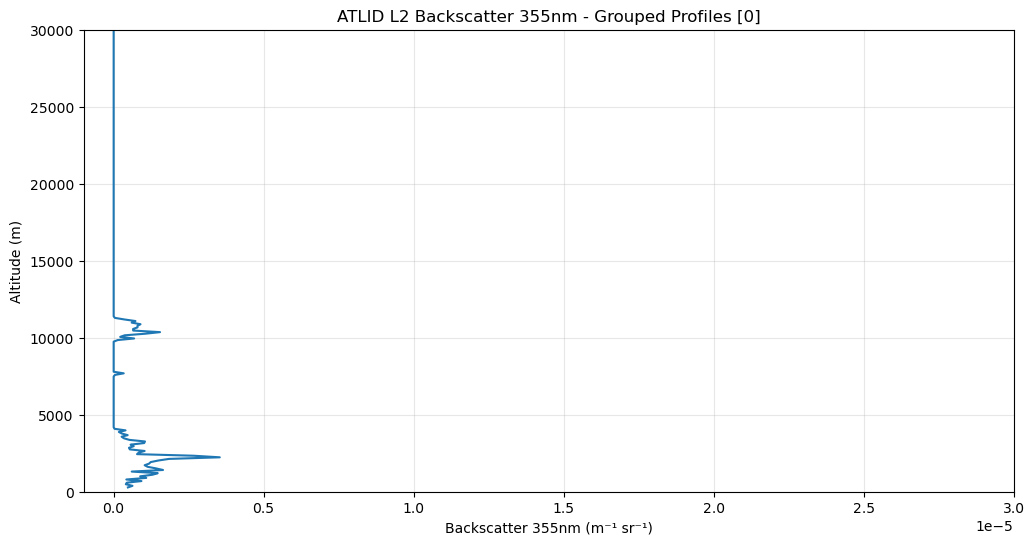

In [ ]:
# get grouped profiles 

backscatter_atlid_grouped, alt_atlid_grouped = get_grouped_profiles(backscatter_atlid, alt_atlid, group_size=5)
print(alt_atlid_grouped.shape, alt_atlid_grouped.shape)

profile_index = 0
# plot an example of grouped profiles

plt.figure(figsize=(12, 6))
plt.plot( backscatter_atlid_grouped[profile_index] , alt_atlid_grouped[profile_index])
plt.xlabel('Backscatter 355nm (m⁻¹ sr⁻¹)')
plt.ylabel('Altitude (m)')
plt.title(f'ATLID L2 Backscatter 355nm - Grouped Profiles [{profile_index}]')
plt.ylim(0, 30000)
plt.xlim(-1e-6, 3e-5)
plt.grid(True, alpha=0.3)
plt.show()



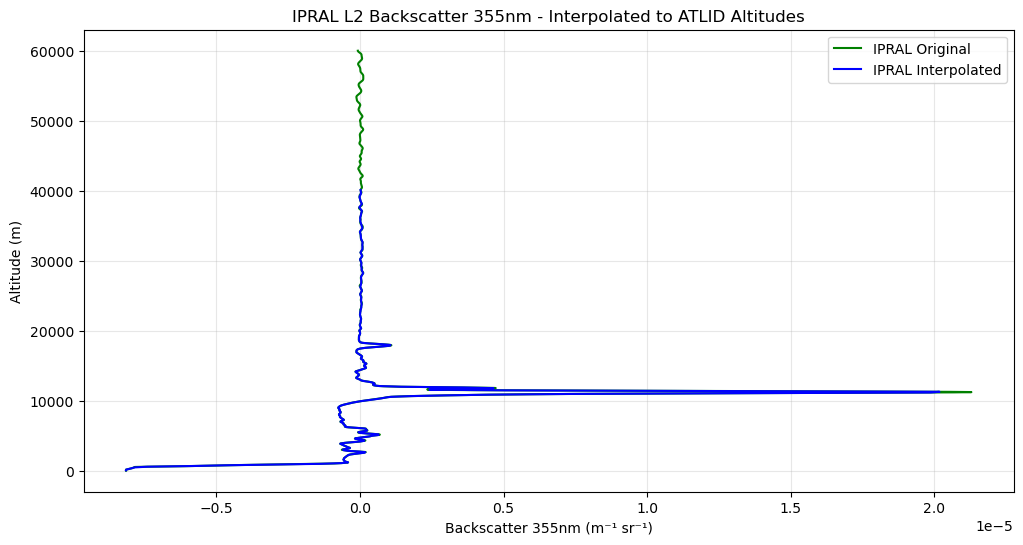

In [7]:
# interpolate ipral to atlid altitudes


backscatter_ipral_interp, _ = interpolate_ipral_to_atlid(backscatter_ipral, alt_ipral, alt_atlid_grouped[profile_index])

plt.figure(figsize=(12, 6))
plt.plot( backscatter_ipral , alt_ipral, label='IPRAL Original', color='green' )
plt.plot( backscatter_ipral_interp , alt_atlid_grouped[profile_index], label='IPRAL Interpolated' , color='blue')
plt.xlabel('Backscatter 355nm (m⁻¹ sr⁻¹)')
plt.ylabel('Altitude (m)')
plt.title('IPRAL L2 Backscatter 355nm - Interpolated to ATLID Altitudes')
# plt.ylim(0, 30000)
# plt.xlim(-1e-6, 3e-5)
plt.grid(True, alpha=0.3)
plt.legend()

In [8]:
# calculate correlation for all grouped profiles

correlations = []
for i, (backscatter_atlid, altitude_atlid) in enumerate(zip(backscatter_atlid_grouped, alt_atlid_grouped)):
    backscatter_ipral_interp, _ = interpolate_ipral_to_atlid(backscatter_ipral, alt_ipral, altitude_atlid)
    corr, pval = calculate_correlation(backscatter_atlid, backscatter_ipral_interp, altitude_atlid, [5000, 25000])
    correlations.append((i, corr, pval))


# Filter valid correlations
valid_corr = [(i, c, p) for i, c, p in correlations if c is not None]

# Get max absolute value
best_idx, best_corr, best_pval = max(valid_corr, key=lambda x: abs(x[1]))

print(f'Best correlation: {best_corr:.4f}, p-value: {best_pval:.4e}, index: {best_idx}')

Best correlation: 0.8585, p-value: 4.1169e-47, index: 32


/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


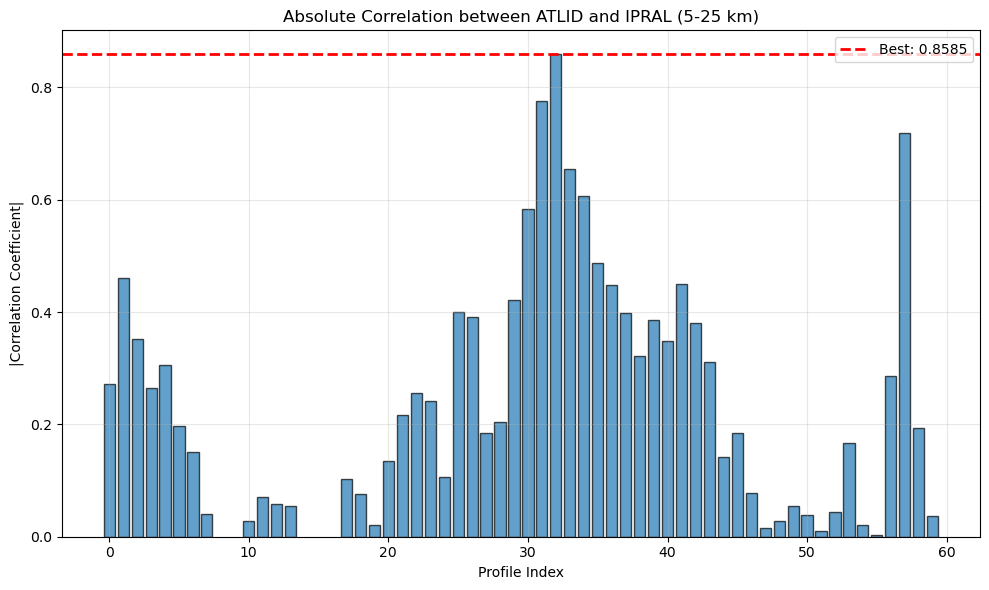

In [9]:
# plot the correlations histogram

indices = [i for i, c, p in valid_corr]
abs_corrs = [abs(c) for i, c, p in valid_corr]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(indices, abs_corrs, edgecolor='black', alpha=0.7)
plt.axhline(abs(best_corr), color='red', linestyle='--', linewidth=2, label=f'Best: {abs(best_corr):.4f}')
plt.xlabel('Profile Index')
plt.ylabel('|Correlation Coefficient|')
plt.title('Absolute Correlation between ATLID and IPRAL (5-25 km)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

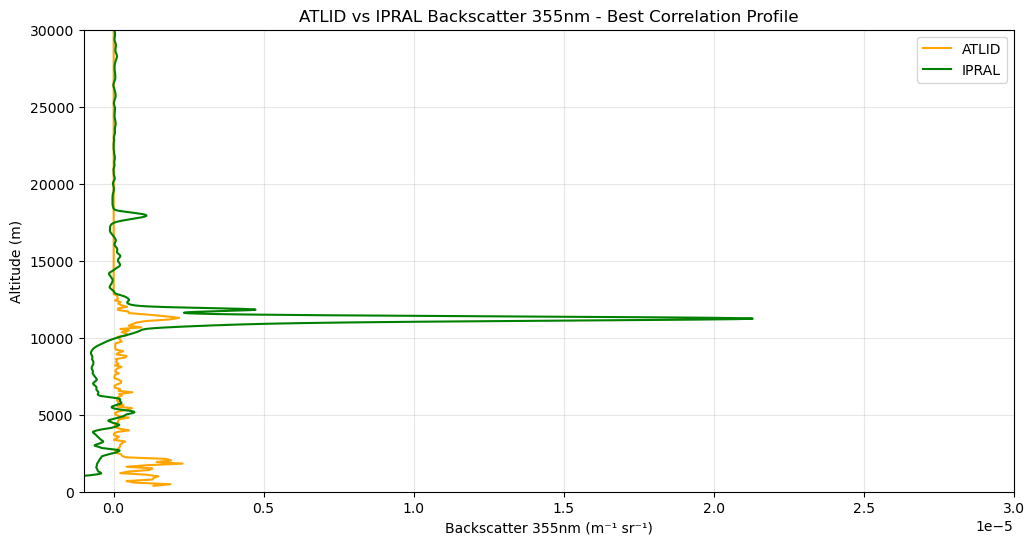

In [10]:
# plot atlid and ipral Backscatter 355nm together for the best correlation profile

plt.figure(figsize=(12, 6))
plt.plot( backscatter_atlid_grouped[best_idx] , alt_atlid_grouped[best_idx], label='ATLID', color='orange' )
plt.plot( backscatter_ipral , alt_ipral, label='IPRAL', color='green' )
plt.xlabel('Backscatter 355nm (m⁻¹ sr⁻¹)')
plt.ylabel('Altitude (m)')
plt.title('ATLID vs IPRAL Backscatter 355nm - Best Correlation Profile')
plt.ylim(0, 30000)
plt.xlim(-1e-6, 3e-5)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
